In [86]:
NotebookTitle = "Initialization Tests - dont zero 4th channel weights"

In [87]:
!pip install jovian --upgrade -q
!pip install kaggle --upgrade -q

In [1]:
import os
import gc
import numpy as np
import jovian
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy, error_rate
from fastai.callbacks import *

from PIL import Image
# from tqdm.notebook import tqdm 
from tqdm import tqdm_notebook as tqdm
from pathlib import Path

<IPython.core.display.Javascript object>

In [2]:
!ls /home/ubuntu/datasets/human-protein-atlas/

external_data_raw      train_1024by1024  train_labels_oversampled.csv
models		       train_2048by2048  train_labels_oversampled_v2.csv
sample_submission.csv  train_512by512
test_512by512	       train.csv


In [3]:
size = 512
# size = 256

PATH = '/home/ubuntu/datasets/human-protein-atlas/'
TRAIN = '/home/ubuntu/datasets/human-protein-atlas/train_1024by1024/'
TEST = '/home/ubuntu/datasets/human-protein-atlas/test_512by512//'

# TRAIN = '../input/human-protein-atlas-image-classification/train/'
# TEST = '../input/human-protein-atlas-image-classification/test/'

LABELS = '/home/ubuntu/datasets/human-protein-atlas/train.csv'

#SPLIT = './protein-trainval-split/'

path_working = Path('/home/ubuntu/datasets/human-protein-atlas/')

In [94]:
# channels = ['_yellow', '_red', '_green', '_blue']

In [4]:
index_class_dict = {
0:  'Nucleoplasm',
1:  'Nuclear membrane',
2:  'Nucleoli',   
3:  'Nucleoli fibrillar center',
4:  'Nuclear speckles',
5:  'Nuclear bodies',
6:  'Endoplasmic reticulum',   
7:  'Golgi apparatus',
8:  'Peroxisomes',
9:  'Endosomes',
10:  'Lysosomes',
11:  'Intermediate filaments',
12:  'Actin filaments',
13:  'Focal adhesion sites',   
14:  'Microtubules',
15:  'Microtubule ends',  
16:  'Cytokinetic bridge',   
17:  'Mitotic spindle',
18:  'Microtubule organizing center',  
19:  'Centrosome',
20:  'Lipid droplets',
21:  'Plasma membrane',   
22:  'Cell junctions', 
23:  'Mitochondria',
24:  'Aggresome',
25:  'Cytosol',
26:  'Cytoplasmic bodies',   
27:  'Rods & rings' }

In [96]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb/data

#using a split that includes all classes in val
# with open(os.path.join(SPLIT,'tr_names.txt'), 'r') as text_file:
#     tr_n = text_file.read().split(',')
# with open(os.path.join(SPLIT,'val_names.txt'), 'r') as text_file:
#     val_n = text_file.read().split(',')
# test_names = sorted({f[:36] for f in os.listdir(TEST)})
# print(len(tr_n),len(val_n))

28575 2497


In [97]:
# https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb/data

# See discussion: https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/74374

#creating duplicates for rare classes in train set
# class Oversampling:
#     def __init__(self,path):
#         self.train_labels = pd.read_csv(path).set_index('Id')
#         self.train_labels['Target'] = [[int(i) for i in s.split()] 
#                                        for s in self.train_labels['Target']]  
#         #set the minimum number of duplicates for each class
#         self.multi = [1,1,1,1,1,1,1,1,
#                       4,4,4,1,1,1,1,4,
#                       1,1,1,1,2,1,1,1,
#                       1,1,1,4]

#     def get(self,image_id):
#         labels = self.train_labels.loc[image_id,'Target'] if image_id \
#           in self.train_labels.index else []
#         m = 1
#         for l in labels:
#             if m < self.multi[l]: m = self.multi[l]
#         return m
    
# s = Oversampling(LABELS)
# tr_n = [idx for idx in tr_n for _ in range(s.get(idx))]
# print(len(tr_n),flush=True)

29016


In [98]:
# del s
# gc.collect()

29

In [7]:
train  = pd.read_csv('/home/ubuntu/datasets/human-protein-atlas/train.csv')
train.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [59]:
train  = pd.read_csv('/home/ubuntu/codebase/my_github/kaggle-competitions/human-protein-atlas/approach_2/input/train_folds_combined_data.csv')
train.head()

,Id,Target,Nucleoplasmn,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings,kfold
0,28815_1478_D12_4,[25 0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
1,28656_251_D12_2,[6],0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,53738_986_C2_1,[2],0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
3,59977_1105_A8_8,[25 0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,4
4,26745_si23_G4_4,[0],1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [60]:
train['Target'] = train['Target'].map(lambda x: x.replace('[','').replace(']',''))
train['Target']

0         25  0
1             6
2             2
3         25  0
4             0
          ...  
105673        2
105674      5 0
105675        0
105676       25
105677    25 21
Name: Target, Length: 105678, dtype: object

In [49]:
# train_df = train[(train['kfold']==1) | (train['kfold']==2) | (train['kfold']==3) | (train['kfold']==4)]
# val_df = train[train['kfold']==0]

In [61]:
# train_df.shape, val_df.shape

In [62]:
train_df = train.iloc[:,:2]
train_df.iloc[:7,:]

,Id,Target
0,28815_1478_D12_4,25 0
1,28656_251_D12_2,6
2,53738_986_C2_1,2
3,59977_1105_A8_8,25 0
4,26745_si23_G4_4,0
5,26605_290_D4_2,25 21
6,39270_763_C11_1,25 0 21


In [63]:
# val_df = val_df.iloc[:,:2]
# val_df.iloc[:7,:]

In [64]:
train_df.head(10)

,Id,Target
0,28815_1478_D12_4,25 0
1,28656_251_D12_2,6
2,53738_986_C2_1,2
3,59977_1105_A8_8,25 0
4,26745_si23_G4_4,0
5,26605_290_D4_2,25 21
6,39270_763_C11_1,25 0 21
7,67191_1249_C11_2,23
8,c2194a88-bbab-11e8-b2ba-ac1f6b6435d0,25 1
9,29ef04e0-bbca-11e8-b2bc-ac1f6b6435d0,4


In [65]:
train_df.shape #, val_df.shape

(105678, 2)

In [100]:
# import zipfile

# # resize each of the R,G,B and Y images for the specified image name
# def resize_channel_images( image_name, source_path, target_path, size=256 ):
#     # loop over each of the colors
#     for color in channels:        
#         source_file = os.path.join(source_path, image_name) + color + '.png'       
#         im = Image.open(source_file)
                        
#         # resize to the defined size
#         im = im.resize((size, size))    
        
#         # save the resized RGB image        
#         target_file = os.path.join(target_path, image_name) + color + '.png'
#         im.save(target_file)            
        
# def create_resized_images( a_source_path, a_target_path, a_df, a_size ):
#     if not a_target_path.exists(): 
#         a_target_path.mkdir(parents=True, exist_ok=True) 
#         print(f"created folder {a_target_path}")    
        
#         # resize all the images from the specified folder
#         for idx in tqdm(range(a_df.shape[0])):        
#             image_name = a_df.iloc[idx].Id
#             resize_channel_images( image_name, a_source_path, a_target_path, size=a_size )         
            
#         gc.collect()
#     else:
#         print(f"folder {a_target_path} already exists")        
        

# # remove the specified folder and contents if it exists
# def remove_image_folder( path ):
#     if path.exists(): 
#         shutil.rmtree(path)   


# # target_zip = path_working/'train_256.zip'    
# train_256 = path_working/'train_256'

# # creating 256 test images    
# # remove_image_folder( train_256 )

# if train_256.exists():
#     print("Resized images exist")
# else:
#     print('Creating resized training images')
#     create_resized_images( TRAIN, train_256, train_df, size )    

Resized images exist


In [101]:
# big_train_df = pd.DataFrame(tr_n, columns =['Id']) 
# big_train_df = pd.merge(big_train_df, train_df, on='Id')
# big_train_df.shape

(29016, 2)

In [102]:
# big_val_df = pd.DataFrame(val_n, columns =['Id']) 
# big_val_df = pd.merge(big_val_df, train_df, on='Id')
# big_val_df.shape

(2497, 2)

In [103]:
# train_df = pd.concat([big_train_df, big_val_df])

In [105]:
# del big_train_df
# del big_val_df
# gc.collect()

22

## RGB Images for display only

In [107]:
# # import Fastai vision to get their Image class
# from fastai.vision.image import *

# # taken from : https://github.com/wdhorton/protein-atlas-fastai/blob/master/utils.py
# # discussion : https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039
# # adapted from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb
# def open_4_channel(fname):
#     fname = str(fname)
#     # strip extension before adding color
#     if fname.endswith('.png'):
#         fname = fname[:-4]
#     colors = ['red','green','blue','yellow']
#     flags = cv2.IMREAD_GRAYSCALE
    
#     img = [cv2.imread(fname+'_'+color+'.png', flags).astype(np.float32)/255
#            for color in colors]
    
#     # convert from a [512,512,4] tensor to a [4,512,512] tensor
#     x = np.stack(img, axis=-1)    
    
#     # create a Fastai image from the tensor
#     return Image(pil2tensor(x, np.float32).float())

## Create the DataBunch

In [55]:
batch_size = 12

In [56]:
# read the submission file to get the names of the test images
test_df = pd.read_csv('/home/ubuntu/datasets/human-protein-atlas/sample_submission.csv')
test_df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,0
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,0
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0


In [57]:
np.random.seed(42)

In [78]:
test = ImageList.from_df(test_df,TEST,folder='.',suffix='.png')

In [79]:
val_n = train.loc[(train['kfold']==0),'Id']
val_n.values

array(['26605_290_D4_2', '39270_763_C11_1', '17816_620_D12_4', '59137_1239_H10_4', ...,
       '7bb29910-bba5-11e8-b2ba-ac1f6b6435d0', 'ba10a22e-bbc3-11e8-b2bc-ac1f6b6435d0', '41219_502_E9_1',
       '20470_248_H8_1'], dtype=object)

In [71]:
def isValidationImage(file_path):
    return Path(file_path).stem in val_n.values

In [113]:
# initially train on the 256 images
# - done for epochs 0 to 20 -> gives good results even without scaline test images to 256
# TRAIN = train_256

# now train on full sized images
TRAIN = './train/'


In [80]:
src = (ImageList.from_df(train_df,TRAIN,suffix='.png')  
                .split_by_valid_func(isValidationImage)   
                .label_from_df(cols='Target',label_delim=' ')
                .add_test(test))

In [74]:
# src.train.x.create_func = open_4_channel
# src.train.x.open = open_4_channel

# src.valid.x.create_func = open_4_channel
# src.valid.x.open = open_4_channel

In [75]:
# src.test.x.create_func = open_4_channel
# src.test.x.open = open_4_channel

In [83]:
protein_stats = ([0.08069, 0.05258, 0.05487], [0.13704, 0.10145, 0.15313])

In [76]:
# trn_tfms,_ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

# use the default set of fastai transforms
tfms = get_transforms()

In [84]:
data = ( src.transform(tfms=tfms)       
        .databunch(bs=batch_size)
        .normalize(protein_stats))

In [120]:
# data = ( src     
#         .databunch(bs=batch_size)
#         .normalize(protein_stats))

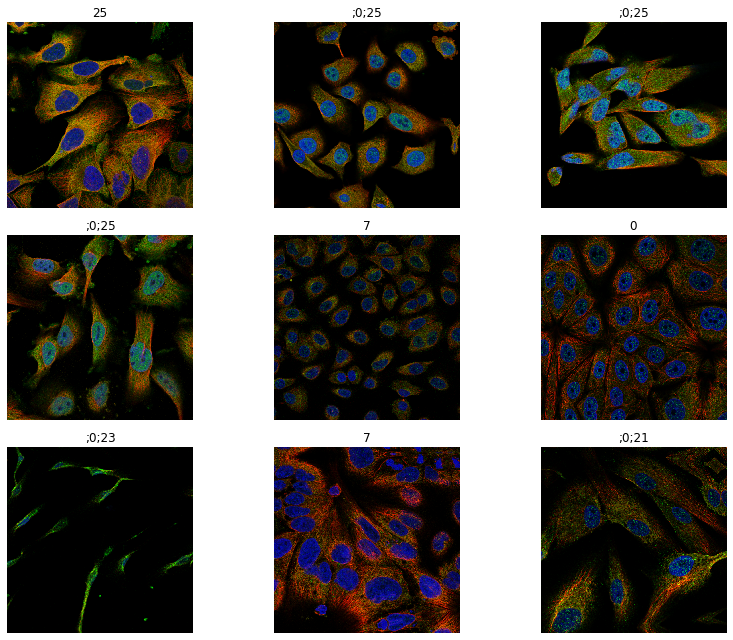

In [85]:
data.show_batch( rows=3, figsize=(12,9) )

# Train the model

### 4 Channel Resnet

In [123]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [124]:
       
# class Resnet4Channel(nn.Module):
#     def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
#         super().__init__()

#         encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        
#         # we initialize this conv to take in 4 channels instead of 3
#         # we keeping corresponding weights for first 3 channels from https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb        
#         w = encoder.conv1.weight
#         self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)               

#         # get the weights from the 4th channel of the new conv layer, retaining their shape
# #         channel_4_weights = self.conv1.weight[:,3:4,:,:]
        
#         # get the initial weights for the 4th channel from the 1st channel of the pretrained model
#         channel_4_weights = w[:,:1,:,:]

#         # put the weights from the pretrained model into the first 3 channels and retain the 
#         # default weights in the 4th channel
#         self.conv1.weight = nn.Parameter(torch.cat((w,channel_4_weights),dim=1))   
            
        
#         self.bn1 = encoder.bn1
#         self.relu = nn.ReLU(inplace=True) 
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

#         self.layer1 = encoder.layer1
#         self.layer2 = encoder.layer2
#         self.layer3 = encoder.layer3
#         self.layer4 = encoder.layer4
        
#         self.avgpool = encoder.avgpool
#         self.fc = nn.Linear(512 * (1 if encoder_depth==34 else 4), num_classes)
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.bn1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)

#         x = self.layer1(x)
#         x = self.layer2(x)
#         x = self.layer3(x)
#         x = self.layer4(x)

#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)

#         return x    

In [90]:
# def RGBYResnet50(pretrained):
#     return Resnet4Channel(encoder_depth=50)

# # copied from https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py
def _resnet_split(m): return (m[0][6],m[1])

In [126]:
# learn = create_cnn(
#     data,
#     resnet50,
#     cut=-2,
#     split_on=_resnet_split,
#     loss_func=F.binary_cross_entropy_with_logits,
#     path=path,    
#     metrics=[f1_score], 
# )

In [86]:
from torch import Tensor
from jovian.utils.records import log_hyperparams, log_metrics, reset
from jovian.utils.logger import log


class JovianFastaiCallback(Callback):
    """Fastai callback to automatically log hyperparameters and metrics.
    Args:
        learn (Learner): A learner object reference of your current model.
        arch_name (string): A name for the model you're training. 
    Example
        .. code-block::
            from jovian.callbacks.fastai import JovianFastaiCallback
            jvn_cb = JovianFastaiCallback(learn, 'res18')
            learn.fit_one_cycle(5, callbacks = jvn_cb)
    .. admonition:: Tutorial
        Visit `this`_ for a detailed example on using the keras callback, also visit the *Records* tab
        to see all the logs of that notebook logged by the callback.
    .. _this: https://jovian.ml/PrajwalPrashanth/7f16274fc3224d829941bc2553ef6061?utm_source=docs
    """

    def __init__(self, learn: Learner, arch_name=None, reset_tracking=True):
        self.learn = learn
        self.arch_name = arch_name
        self.met_names = ['epoch', 'train_loss']
        # existence of validation dataset
        self.valid_set = self.learn.data.valid_dl.items.size > 0
        self.reset_tracking = reset_tracking
        if self.valid_set:
            self.met_names.append('valid_loss')

    def on_train_begin(self, n_epochs: int, metrics_names: list, **ka):
        if self.reset_tracking:
            reset('hyperparams', 'metrics')
        hyp_dict = {
            'epochs': n_epochs,
            'batch_size': self.learn.data.batch_size,
            'loss_func': str(self.learn.loss_func.func),
            'opt_func': str(self.learn.opt_func.func).split("'")[1],
            'weight_decay': self.learn.wd,
            'learning_rate': f'{self.learn.opt.lr:.5f}'
        }
        if self.arch_name: hyp_dict['arch_name'] = self.arch_name
        log_hyperparams(hyp_dict)

        if self.valid_set:
            # change the accuracy name to match the value in V2 notebooks
            modified_names = [sub.replace('accuracy_thresh', 'accuracy_multi') for sub in metrics_names] 
            self.met_names.extend(modified_names)

    def on_epoch_end(self, epoch: int, smooth_loss: Tensor, last_metrics: list, **ka):
        met_values = [epoch,
                      f'{smooth_loss.item():.5f}']  # smoothened avg. train loss for the epoch

        if self.valid_set:
            # last_metrics is a list with first elem as valid_loss followed by all
            # the metrics of the learner           
            met_values.extend([f'{v.item():.5f}' for v in last_metrics])
            
        log_metrics(dict(zip(self.met_names, met_values)))

    def on_train_end(self, **ka):
        if not self.valid_set:
            log('Metrics apart from train_loss are not calculated in fastai without a validation dataset')

In [87]:
class SaveModelCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:str='improvement', name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every,self.name = every,name
        if self.every not in ['improvement', 'epoch']:
            warn(f'SaveModel every {self.every} is invalid, falling back to "improvement".')
            self.every = 'improvement'

    def jump_to_epoch(self, epoch:int)->None:
        try:
            self.learn.load(f'{self.name}_{epoch-1}', purge=False)
            print(f"Loaded {self.name}_{epoch-1}")
        except: print(f'Model {self.name}_{epoch-1} not found.')

    def on_epoch_end(self, epoch:int, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."
        if self.every=="epoch": self.learn.save(f'{self.name}_{epoch}')
        else: #every="improvement"
            current = self.get_monitor_value()
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at epoch {epoch} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        "Load the best model."
        if self.every=="improvement" and os.path.isfile(self.path/self.model_dir/f'{self.name}.pth'):
            print(f'Loading best model: {self.name}')
            self.learn.load(f'{self.name}', purge=False)

F1 Metric taken from [here](https://www.kaggle.com/iafoss/pretrained-resnet34-with-rgby-0-460-public-lb)

In [88]:
# note 'n' below is the number of classes - in the protein problem there are 28
class F1:
    __name__ = 'f1_score'
    def __init__(self,n=28):
        self.n = n     
        self.TP = torch.zeros(1, self.n).cuda()
        self.FP = torch.zeros(1, self.n).cuda()
        self.FN = torch.zeros(1, self.n).cuda()

    def __call__(self,preds,targs,th=0.0):
        preds = (preds > th).int()
        targs = targs.int()       
        self.TP += (preds*targs).float().sum(dim=0)
        self.FP += (preds > targs).float().sum(dim=0)
        self.FN += (preds < targs).float().sum(dim=0)
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6)).mean()
        return score

    def reset(self):
        #macro F1 score
        score = (2.0*self.TP/(2.0*self.TP + self.FP + self.FN + 1e-6))
        print('F1 macro:',score.mean(),flush=True)
        self.TP = torch.zeros(1, self.n).cuda()
        self.FP = torch.zeros(1, self.n).cuda()
        self.FN = torch.zeros(1, self.n).cuda()

class F1_callback(Callback):
    def __init__(self, n=28):
        self.f1 = F1(n)

    def on_epoch_end(self, metrics):
        self.f1.reset()

In [91]:
# write to commit log
os.system('echo '+ 'Creating and training model')

arch = models.resnet50
# arch = RGBYResnet50
acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.2)
# f1_score = partial(fbeta, thresh=0.2, beta=1)

f1_callback = F1_callback(n=data.c)


learn = cnn_learner(data, arch, split_on=_resnet_split, metrics=[acc_02,f1_callback.f1])
# learn = cnn_learner(data, arch, split_on=_resnet_split, metrics=[acc_02, f1_score])

In [92]:
learn.model_dir = path_working

In [93]:
path_working

PosixPath('/home/ubuntu/datasets/human-protein-atlas')

In [133]:
# lr_find(learn)
# learn.recorder.plot(suggestion=True)

In [94]:
lr = 3e-2

In [95]:
callbacks = [    
    SaveModelCallback(learn, monitor='f1_score',mode='max'),    
    ShowGraph(learn),
#     EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
    JovianFastaiCallback(learn, 'resnet50', reset_tracking=True)    
]
learn.callbacks = callbacks

In [96]:
gc.collect()

19660

In [97]:
# restart after exit - set start_epoch to zero if dont want to start from a saved best model
# - used when GCP dumps us out during a run
# - set start epoch to the epoch from which the best model was generated
start_epoch = 0

# the current number of epochs trained
total_epochs = 0


def train( frozen, epochs_to_train = 5, use_existing = True ):
    
    global total_epochs  
    global start_epoch
    
    if start_epoch > 0:
        total_epochs = start_epoch
        learn.load('bestmodel');    
        epochs_to_train = epochs_to_train - (start_epoch % 5)
        print( f'Loading best model from epoch {start_epoch} and training for {epochs_to_train} further epochs in this set')
        
        # reset the start_epoch value so it wont be used on the next call
        start_epoch = 0
    
    total_epochs += epochs_to_train
    
    # test if the model has already been trained to this number of epochs
    saved_filename = f'{total_epochs}_epochs'
    saved_filepath = path_working/f'{saved_filename}.pth'
    print(f'Testing for file: f{saved_filepath}')
        
    if use_existing and os.path.isfile(saved_filepath):
        print (f'File exists: {saved_filename}')
        learn.load(saved_filename)
    else:        
        if frozen:
            print(f'Training Frozen - from epochs {total_epochs-epochs_to_train} to {total_epochs}')
            learn.freeze() 
            learn.fit_one_cycle(epochs_to_train, slice(lr))
        else:
            print(f'Training Un-Frozen - from epochs {total_epochs-epochs_to_train} to {total_epochs}')
            learn.unfreeze()  
            learn.fit_one_cycle(epochs_to_train, slice(3e-5, lr/5))            
            
        learn.save(saved_filename)                  

In [138]:
# # initialization tests - only 10 epochs
# train( frozen = True, use_existing = False )
# train( frozen = False, use_existing = False )

In [98]:
max_epochs = 30
while total_epochs < max_epochs:
    train( frozen = True )
    train( frozen = False)

Testing for file: f/home/ubuntu/datasets/human-protein-atlas/5_epochs.pth
Training Frozen - from epochs 0 to 5
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Hyperparams logged.


epoch,train_loss,valid_loss,accuracy_thresh,f1_score,time


RuntimeError: cuda runtime error (11) : invalid argument at /pytorch/aten/src/THC/THCGeneral.cpp:405

## Create the predictions

In [140]:
learn.load('20_epochs', purge=False);

In [ ]:
# write to commit log
os.system('echo '+ 'Generating predictions')

preds,_ = learn.get_preds(DatasetType.Test)

In [ ]:
thresh = 0.2
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
labelled_preds[:5]

In [ ]:
learn.data.test_ds.items[0]

In [ ]:
Path(learn.data.test_ds.items[0]).stem

In [ ]:
# convert the image path strings to just the file name with no extension
fnames = [Path(f).stem for f in learn.data.test_ds.items]

In [ ]:
sample_list = list(test_df.Id)
pred_dic = dict((key, value) for (key, value) in zip(fnames,labelled_preds))
pred_list_cor = [pred_dic[id] for id in sample_list]
df = pd.DataFrame({'Id':sample_list,'Predicted':pred_list_cor})
df.to_csv('protein_classification.csv', header=True, index=False)

In [ ]:
df.head()

In [ ]:
# Submit (you can find this command from the section "My submissions" within the competition page)
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification.csv -m "Message"

# View results
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt

In [ ]:
import time

# sometimes, when Kaggle is busy, it takes a while to get the results file
# - so check the file is ok and try again if its not
def submission_pending():
    with open("results.txt") as file:  
        lines = file.readlines() 
        data = lines[2].split()  
        print(lines[2])
        if data[5] == "pending" or data[5] == "None" or data[6] == "None": 
            print("Kaggle submission pending")
            return True
        else:
            print(f'Public: {data[5]}, Private: {data[6]}')
        return False

tries = 0
max_tries = 5
while submission_pending() and tries < max_tries:
    
    # wait 30 seconds
    time.sleep(30)
    
    # regenerate the results file
    !kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
    tries += 1

In [ ]:
# read the 3rd line of the results - this contains the most recent submission
with open("results.txt") as file:  
    lines = file.readlines() 
    data = lines[2].split() 
        
    print(lines[0])
    print(lines[1])
    print(lines[2])
        
    metrics = {
        'public':data[5],
        'private':data[6]
    }
    jovian.log_metrics(metrics)          

In [ ]:
os.system('echo '+ 'Notebook complete')

In [ ]:
# wait for 5 seconds to let the notebook settle down before commiting to Jovian
time.sleep(5)

In [ ]:
# commit the results of the experiment to Jovian
jovian_commit()